In [18]:
# Imports
import numpy as np 
import pandas as pd
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.layers import Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adamax
from keras.applications.densenet import DenseNet121
from keras import regularizers
from livelossplot import PlotLossesKeras
from keras.utils import multi_gpu_model
#from tqdm import TQDMNotebookCallback

In [36]:
#Hyperparameters
learning_rate = 0.001
sample_count=85000
batch_size = 256
num_classes = 1
epochs = 200
data_augmentation = True
filters = 32
kernel_size = (3,3)
pool_size = (2,2)
training_ratio=0.90
IMAGE_SIZE = 96
verbosity = 2
MODEL_FILE = "model.h5"
TRAINING_LOGS_FILE = "training_logs.csv"
TESTING_BATCH_SIZE = 5000
ROC_PLOT_FILE = "roc.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

In [20]:
# Data (https://www.kaggle.com/c/histopathologic-cancer-detection/data)
#input_dir = '../input/'
input_dir = '/home/samsungpc/Desktop/project1/input/'
training_dir = '/home/samsungpc/Desktop/project1/input/train/'
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[7].split('.')[0])
labels = pd.read_csv('/home/samsungpc/Desktop/project1/input/train_labels.csv')
data_frame = data_frame.merge(labels, on='id')

# Data (https://www.kaggle.com/c/histopathologic-cancer-detection/data)
#input_dir = '../input/'
negatives = data_frame[data_frame.label == 0].sample(sample_count)
positives = data_frame[data_frame.label == 1].sample(sample_count)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]
data_frame['image'] = data_frame['path'].map(imread)

training_path = '../training'
validation_path = '../validation'

for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

training, validation = train_test_split(data_frame, train_size=training_ratio, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)

for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(data_frame.loc[image,'label'])
        destination = os.path.join(path, label, file_name)
        if not os.path.exists(destination):
            source = os.path.join(input_dir + 'train', file_name)
            shutil.copyfile(source, destination)

/home/samsungpc/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [21]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [22]:
# Data generation
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                 batch_size=batch_size,
                                                                 class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=batch_size,
                                                                              class_mode='binary')

Found 220025 images belonging to 2 classes.
Found 161903 images belonging to 2 classes.


In [37]:
#Model
model = Sequential()

model.add(DenseNet121(include_top=False, 
                      weights='imagenet', 
                      input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                      pooling='max'))
#model.add(Flatten())
model.add(BatchNormalization())
#model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))   
model.layers[0].trainable=False                                             

In [38]:
#Loss and Optimizer
parallel_model=multi_gpu_model(model, gpus=2)
parallel_model.compile(optimizer=Adamax(lr=learning_rate, epsilon =1e-08),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               131200    
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
__________

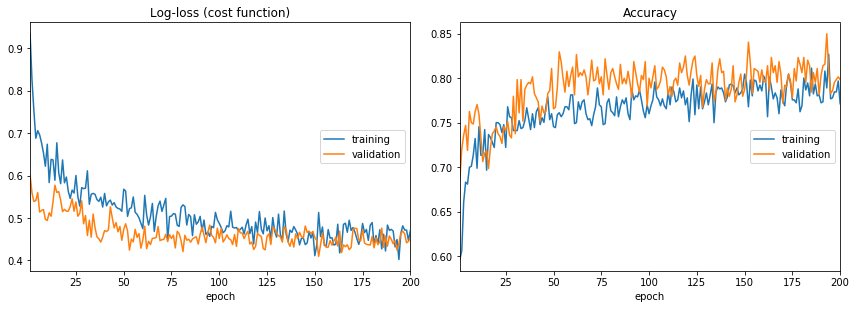

Log-loss (cost function):
training   (min:    0.402, max:    0.934, cur:    0.470)
validation (min:    0.409, max:    0.601, cur:    0.453)

Accuracy:
training   (min:    0.596, max:    0.827, cur:    0.771)
validation (min:    0.686, max:    0.850, cur:    0.798)

Epoch 00200: val_acc did not improve from 0.85000


In [39]:
#  Training

history = parallel_model.fit_generator(training_generator, 
                              steps_per_epoch=len(training_generator)/batch_size, 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator)/batch_size,
                              epochs=epochs,
                              verbose=verbosity,
                              callbacks=[PlotLossesKeras(),
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_acc',
                                                         verbose=verbosity,
                                                         save_best_only=True,
                                                         mode='max'),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False)])

In [40]:
# evaluate the model
#scores = model.evaluate(training_generator, verbose=1)
#print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
test_df = pd.read_csv('/home/samsungpc/Desktop/project1/input/sample_submission.csv')

from matplotlib.pyplot import imread
# Kaggle testing
from glob import glob
TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join('/home/samsungpc/Desktop/project1/input/test/','*.tif'))
submission = pd.DataFrame()
print(len(testing_files))
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[7].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
submission.to_csv('submission_new_model.csv', index=False, header=True)
print(submission.head())

57458
0.0
13.923213477670645
27.84642695534129
41.769640433011936
55.69285391068258
69.61606738835323
83.53928086602387
